# -1- IMPORT DES DONNEES
fichiers telecharges depuis :
https://www.data.gouv.fr/fr/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/

In [626]:
# Import des librairies
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates # pour la gestion des dates
from matplotlib.animation import FuncAnimation  # pour animer les graphiques dans le temps
from datetime import datetime # pour la gestion des dates
#%pip install mplcursors  # la première fois si non installé
import mplcursors # pour lecture des bulles avec curseur

In [627]:
# Import de la donnée sous format csv avec séparateur ";" et un format d'encodage compatible
DataCov = pd.read_csv(r'../DATA/covid-hospit-2023-03-31-18h01.csv', encoding='utf-8', sep=';')
MetaCov = pd.read_csv(r'../DATA/metadonnees-donnees-hospitalieres-covid19-maj20210810.csv', encoding='iso-8859-1', sep=';')
#print(DataCov.info())
#print(MetaCov.info())

# -2- TRAITEMENT INITIAL

In [629]:
# Examinons la description qui est faite des données d'après la documentation sur data.gouv:
DfMeta = pd.DataFrame(MetaCov)
pd.set_option('display.max_colwidth', None)
display(DfMeta)
pd.reset_option('display.max_colwidth')

,Colonne,Type,Description_FR,Description_EN,Exemple
0,dep,integer,DÃ©partement,Department,1
1,sexe,integer,Sexe,Sex,0
2,jour,string($date),Date de notification,Date of notice,18/03/2020
3,hosp,integer,Nombre de personnes actuellement hospitalisées,Number of people currently hospitalized,2
4,rea,integer,Nombre de personnes actuellement en services de réanimation ou soins intensifs,Number of people currently in resuscitation or critical care,0
5,rad,integer,Nombre cumulé de personnes retournées à domicile,Total amount of patient that returned home,1
6,dc,integer,Nombre cumulé de personnes décédées à l'hôpital,Total amout of deaths at the hospital,0
7,ssr_usld,integer,Nombre de personnes actuellement en services de SSR ou USLD,NaN,NaN
8,hospconv,integer,Nombre de personnes actuellement en services d'hospitalisation conventionnelle,NaN,NaN
9,autres,integer,Nombre de personnes actuellement en autres types de services,NaN,NaN


In [630]:
#Il pourra être intéressant d'avoir le nom des départements avec leur libellé, donc on importe la table des départements depuis https://www.data.gouv.fr/fr/datasets/code-officiel-geographique-cog/
DataDep = pd.read_csv(r'../DATA/v_departement_2024.csv', encoding='utf-8', sep=',')
DfDep = pd.DataFrame(DataDep)
print(DfDep.info())
display(DfDep)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DEP       101 non-null    object
 1   REG       101 non-null    int64 
 2   CHEFLIEU  101 non-null    object
 3   TNCC      101 non-null    int64 
 4   NCC       101 non-null    object
 5   NCCENR    101 non-null    object
 6   LIBELLE   101 non-null    object
dtypes: int64(2), object(5)
memory usage: 5.7+ KB
None


,DEP,REG,CHEFLIEU,TNCC,NCC,NCCENR,LIBELLE
0,01,84,01053,5,AIN,Ain,Ain
1,02,32,02408,5,AISNE,Aisne,Aisne
2,03,84,03190,5,ALLIER,Allier,Allier
3,04,93,04070,4,ALPES DE HAUTE PROVENCE,Alpes-de-Haute-Provence,Alpes-de-Haute-Provence
4,05,93,05061,4,HAUTES ALPES,Hautes-Alpes,Hautes-Alpes
...,...,...,...,...,...,...,...
96,971,1,97105,3,GUADELOUPE,Guadeloupe,Guadeloupe
97,972,2,97209,3,MARTINIQUE,Martinique,Martinique
98,973,3,97302,3,GUYANE,Guyane,Guyane
99,974,4,97411,0,LA REUNION,La Réunion,La Réunion


In [631]:
#Et on ne garde que l'information qui nous intéresse dans le Df
DfDep = DfDep[['DEP', 'LIBELLE']]
DfDep.columns = DfDep.columns.str.lower()  # pour simplifier ensuite la fusion avec la table principale
DfDep = DfDep.rename(columns={'libelle': 'departement'})  # pour mieux identifier la donnée à partir des noms de colonne

print(DfDep.info())
display(DfDep)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   dep          101 non-null    object
 1   departement  101 non-null    object
dtypes: object(2)
memory usage: 1.7+ KB
None


,dep,departement
0,01,Ain
1,02,Aisne
2,03,Allier
3,04,Alpes-de-Haute-Provence
4,05,Hautes-Alpes
...,...,...
96,971,Guadeloupe
97,972,Martinique
98,973,Guyane
99,974,La Réunion


In [632]:
# De même il pourra être utile plus tard d'afficher la colonne 'SEXE' avec leur traduction
dataSex = {0: 'femmes + hommes', 1: 'hommes', 2: 'femmes'}
DfSex = pd.DataFrame(list(dataSex.items()), columns=['sexe', 'genre'])
print(DfSex)

   sexe            genre
0     0  femmes + hommes
1     1           hommes
2     2           femmes


In [633]:
# Commençons à regarder la table plus en détail, notamment pour vérifier que nous n'uaurons pas de problèmes de type pour les clés de fusion :
DfCov = pd.DataFrame(DataCov)
DfCov.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338245 entries, 0 to 338244
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   dep       338245 non-null  object 
 1   sexe      338245 non-null  int64  
 2   jour      338245 non-null  object 
 3   hosp      338245 non-null  int64  
 4   rea       338245 non-null  int64  
 5   HospConv  228140 non-null  float64
 6   SSR_USLD  228140 non-null  float64
 7   autres    228140 non-null  float64
 8   rad       338245 non-null  int64  
 9   dc        338245 non-null  int64  
dtypes: float64(3), int64(5), object(2)
memory usage: 25.8+ MB


In [634]:
DfCov = pd.merge(DfCov, DfSex, on = 'sexe', how = 'left') # on rajoute la colonne de genre explicite
DfCov = pd.merge(DfCov, DfDep, on = 'dep', how = 'left') # on rajoute la colonne avec les noms de département
print(DfCov.info())
display(DfCov)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338245 entries, 0 to 338244
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   dep          338245 non-null  object 
 1   sexe         338245 non-null  int64  
 2   jour         338245 non-null  object 
 3   hosp         338245 non-null  int64  
 4   rea          338245 non-null  int64  
 5   HospConv     228140 non-null  float64
 6   SSR_USLD     228140 non-null  float64
 7   autres       228140 non-null  float64
 8   rad          338245 non-null  int64  
 9   dc           338245 non-null  int64  
 10  genre        338245 non-null  object 
 11  departement  336027 non-null  object 
dtypes: float64(3), int64(5), object(4)
memory usage: 31.0+ MB
None


,dep,sexe,jour,hosp,rea,HospConv,SSR_USLD,autres,rad,dc,genre,departement
0,01,0,2020-03-18,2,0,NaN,NaN,NaN,1,0,femmes + hommes,Ain
1,01,1,2020-03-18,1,0,NaN,NaN,NaN,1,0,hommes,Ain
2,01,2,2020-03-18,1,0,NaN,NaN,NaN,0,0,femmes,Ain
3,02,0,2020-03-18,41,10,NaN,NaN,NaN,18,11,femmes + hommes,Aisne
4,02,1,2020-03-18,19,4,NaN,NaN,NaN,11,6,hommes,Aisne
...,...,...,...,...,...,...,...,...,...,...,...,...
338240,976,0,2023-03-31,0,0,0.0,0.0,0.0,1766,163,femmes + hommes,Mayotte
338241,976,1,2023-03-31,0,0,0.0,0.0,0.0,739,100,hommes,Mayotte
338242,976,2,2023-03-31,0,0,0.0,0.0,0.0,1002,61,femmes,Mayotte
338243,978,0,2023-03-31,0,0,0.0,0.0,0.0,0,0,femmes + hommes,NaN


In [635]:
# 1/ Transformons la colonne 'jour' en datetime
DfCov['jour'] = pd.to_datetime(DfCov['jour'], format="%Y-%m-%d")
# et vérifions sa prise en compte
print(DfCov['jour'].dtype)

datetime64[ns]


In [636]:
# 2/ regardons de quels départements il s'agit
depNa = DfCov[DfCov['departement'].isna()] # on garde une table ne contenant que les clés non trouvées lors de la fusion
depNa['dep'].value_counts()  # on regarde comment sont réparties nos valeurs manquantes

dep
978    2218
Name: count, dtype: int64

In [637]:
# Il ne manque que le département 978, il s'agit de la Polynésie Française. 
# Nous pouvons donc remplacer toute la donnée manquante de 'departement' par le nom de ce département :
DfCov['departement'] = DfCov['departement'].fillna('Polynésie française')
print(DfCov.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338245 entries, 0 to 338244
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   dep          338245 non-null  object        
 1   sexe         338245 non-null  int64         
 2   jour         338245 non-null  datetime64[ns]
 3   hosp         338245 non-null  int64         
 4   rea          338245 non-null  int64         
 5   HospConv     228140 non-null  float64       
 6   SSR_USLD     228140 non-null  float64       
 7   autres       228140 non-null  float64       
 8   rad          338245 non-null  int64         
 9   dc           338245 non-null  int64         
 10  genre        338245 non-null  object        
 11  departement  338245 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(5), object(3)
memory usage: 31.0+ MB
None


In [638]:
# 3/ On crée la seconde table sans les données manquantes de 'HospConv' en espérant qu'il s'agit des mêmes lignes manquantes dans les autres colonnes, comme le suggère le nombre de NaN
DfCov_FullService = DfCov.dropna(subset=['HospConv'])
print(DfCov_FullService.info())
DfCov_FullService.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 228140 entries, 110105 to 338244
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   dep          228140 non-null  object        
 1   sexe         228140 non-null  int64         
 2   jour         228140 non-null  datetime64[ns]
 3   hosp         228140 non-null  int64         
 4   rea          228140 non-null  int64         
 5   HospConv     228140 non-null  float64       
 6   SSR_USLD     228140 non-null  float64       
 7   autres       228140 non-null  float64       
 8   rad          228140 non-null  int64         
 9   dc           228140 non-null  int64         
 10  genre        228140 non-null  object        
 11  departement  228140 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(5), object(3)
memory usage: 22.6+ MB
None


,sexe,jour,hosp,rea,HospConv,SSR_USLD,autres,rad,dc
count,228140.000000,228140,228140.000000,228140.000000,228140.000000,228140.000000,228140.000000,228140.000000,228140.000000
mean,0.996721,2022-03-22 11:59:59.999999744,112.663189,12.187635,61.495625,35.983782,2.994867,3804.820720,704.142790
min,0.000000,2021-03-14 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2021-09-16 18:00:00,28.000000,1.000000,15.000000,6.000000,0.000000,1116.000000,216.000000
50%,1.000000,2022-03-22 12:00:00,63.000000,4.000000,34.000000,18.000000,1.000000,2213.000000,420.000000
75%,2.000000,2022-09-25 06:00:00,133.000000,12.000000,73.000000,44.000000,3.000000,4599.000000,875.000000
max,2.000000,2023-03-31 00:00:00,1868.000000,570.000000,1115.000000,565.000000,170.000000,48210.000000,6463.000000
std,0.815822,NaN,151.593928,24.817998,83.826313,51.997225,5.827842,4691.565325,811.430131


# -3- ANALYSE DE LA DONNEE

In [640]:
DfCov_FullService = DfCov_FullService.copy() # pour éviter l'avertissement sur le fait de travailler sur une image
DfCov_FullService.loc[:, 'Test_Hypo1'] = DfCov_FullService.apply(
    lambda row: row['hosp'] - sum(row[col] for col in ['rea', 'HospConv', 'SSR_USLD', 'autres']), 
    axis=1
)

DfCov_FullService['Test_Hypo1'].describe()

count    228140.000000
mean          0.001280
std           0.035753
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: Test_Hypo1, dtype: float64

In [641]:
# il semble que nous avons quelques valeurs qui atteignent 1, mais vu la moyenne il ne doit pas y en avoir beaucoup.
# Vérifions :
DfCov_FullService['Test_Hypo1'].value_counts()

Test_Hypo1
0.0    227848
1.0       292
Name: count, dtype: int64

In [642]:
# Il doit probablement s'agir d'erreurs de comptage. Nous poursuivrons avec cette hypothèse et allons donc basculer ces hospitalisations dans "autre".
DfCov_FullService.loc[:,'autres'] = DfCov_FullService.loc[:,'autres'] + DfCov_FullService.loc[:,'Test_Hypo1']
# et on teste pour voir si la modification valide notre hypothèse 1
DfCov_FullService.loc[:, 'Test_Hypo1bis'] = DfCov_FullService.apply(
    lambda row: row['hosp'] - sum(row[col] for col in ['rea', 'HospConv', 'SSR_USLD', 'autres']), 
    axis=1
)
DfCov_FullService['Test_Hypo1bis'].describe()

count    228140.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: Test_Hypo1bis, dtype: float64

In [643]:
# Vérifions déjà le volume global
DfCov['genre'].value_counts()

genre
femmes + hommes    113118
hommes             113118
femmes             112009
Name: count, dtype: int64

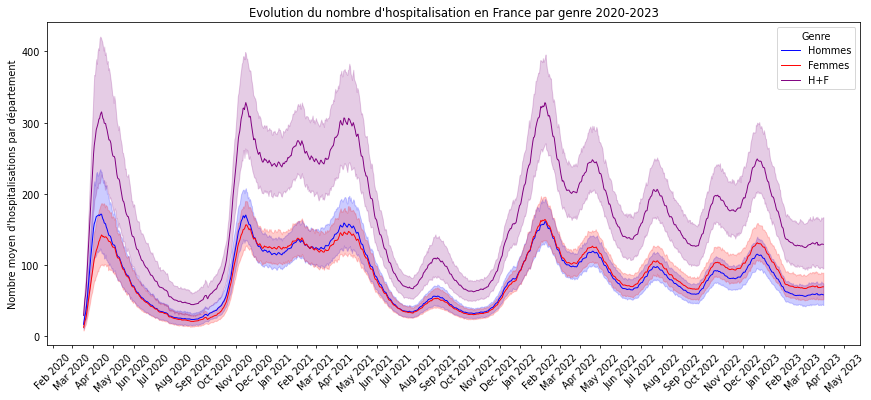

In [644]:
# Apparemment le nombre d'observations comportant des femmes est légèrement inférieur : il est possible que certains départements, certains jours n'hospitalisaient pas de femmes
# Analysons cela sur un graphique, en prenant la donnée du nombre d'hospitalisations

DataH = DfCov[DfCov['sexe'] == 1] # données ne concernant que les hommes
DataF = DfCov[DfCov['sexe'] == 2] # données ne concernant que les femmes
DataFH = DfCov[DfCov['sexe'] == 0] # données ne concernant les deux genres

fig, ax = plt.subplots(figsize=(15,6),dpi=70) 

sns.lineplot(data=DataH, x='jour', y='hosp', color='blue', lw=1, label='Hommes', ax=ax)
sns.lineplot(data=DataF, x='jour', y='hosp', color='red', lw=1, label='Femmes', ax=ax)
sns.lineplot(data=DataFH, x='jour', y='hosp', color='purple', lw=1, label='H+F', ax=ax)

# Habillage général
ax.set_title("Evolution du nombre d'hospitalisation en France par genre 2020-2023")
plt.legend(title="Genre")

# axe des X
ax.set_xlabel('')
ax.xaxis.set_major_locator(mdates.MonthLocator())  # Ticks mensuels
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format mois/année
plt.xticks(rotation=45)

# Axe des Y
ax.set_ylabel("Nombre moyen d'hospitalisations par département")

# Affichage
plt.show()


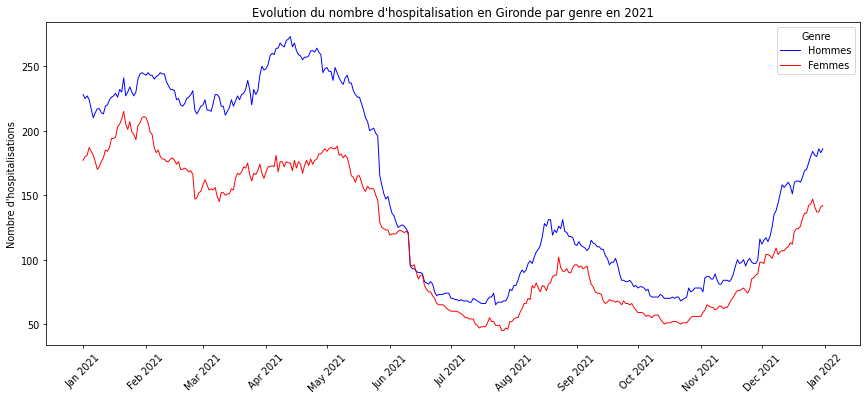

In [645]:
# Si l'on souhaite regarder plus précisément dans un département, sur une année :
DataGir21 = DfCov[(DfCov['dep'] == "33") & (DfCov['jour'].dt.year == 2021)]

# Données par genre
DataH2 = DataGir21[DataGir21['sexe'] == 1]  # hommes
DataF2 = DataGir21[DataGir21['sexe'] == 2]  # femmes

fig, ax = plt.subplots(figsize=(15,6),dpi=70) 

sns.lineplot(data=DataH2, x='jour', y='hosp', color='blue', lw=1, label='Hommes', ax=ax)
sns.lineplot(data=DataF2, x='jour', y='hosp', color='red', lw=1, label='Femmes', ax=ax)

# Habillage général
ax.set_title("Evolution du nombre d'hospitalisation en Gironde par genre en 2021")
plt.legend(title="Genre")

# axe des X
ax.set_xlabel('')
ax.xaxis.set_major_locator(mdates.MonthLocator())  # Ticks mensuels
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format mois/année
plt.xticks(rotation=45)

# Axe des Y
ax.set_ylabel("Nombre d'hospitalisations")

# Affichage
plt.show()


ValueError: quantization error

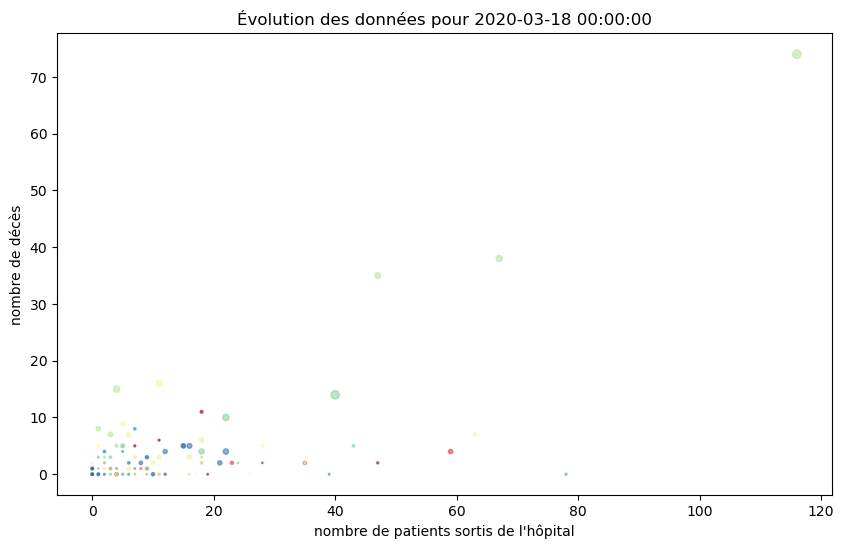

In [664]:

fig, ax = plt.subplots(figsize=[10, 6])

# Attribuons une couleur par département pour mieux les affficher et les repérer
cmap = plt.cm.Spectral  # palette de couleurs Spectral256 couleurs 
unique_deps = DfCov['dep'].unique() # Création d'un index pour chaque département unique
norm = np.linspace(0, 1, len(unique_deps)) # Normalise l'index pour qu'il soit entre 0 et 1
department_colors = {dept: cmap(norm[i]) for i, dept in enumerate(unique_deps)} # Crée un dictionnaire associant chaque département à une couleur
DfCov['couleur_dep'] = DfCov['dep'].map(department_colors) # Ajoute les couleurs à la colonne 'color' dans le DataFrame

# Créer un plot vide
def update_plot(frame):
    ax.clear()  # Nettoyer le plot à chaque frame

    # Filtrer les données pour la date courante
    current_data = DfCov[DfCov['jour'] == frame]

    # Créer le graphique avec les données actuelles
    scatter = ax.scatter(
        current_data['rad'], 
        current_data['dc'], 
        s=current_data['hosp'],
        c=current_data['couleur_dep'], 
        alpha=0.6
    )

    ax.set_title(f"Évolution des données pour {frame}")
    ax.set_xlabel("nombre de patients sortis de l'hôpital")
    ax.set_ylabel('nombre de décès')

    # Curseurs interactifs pour afficher le département
    mplcursors.cursor(scatter, hover=True).connect(
        "add", lambda sel: sel.annotation.set_text(f"Département: {current_data['departement'].iloc[sel.index]}"))

# Créer une animation
dates = sorted(DfCov['jour'].unique())  # Liste des dates uniques

ani = FuncAnimation(fig, update_plot, frames=dates, interval=500, repeat=False)
ani.save('animation.gif', writer='pillow', fps=30)

# Afficher le plot
plt.tight_layout()
plt.show()

On remarque que la majorité des départements se trouve sur un même axe, correspondant à un taux de décès par hospitalisé rentré chez lui.
Seuls quelques bulles se trouvent au-delà de cette droite, il s'agit des départements dont le taux de mortalité serait plus elevé.
